In [279]:
include("other_utils.jl")
using ExpDataSets, Dates, CSV, FileIO, JLD2, Chain, DataFrames, DataFramesMeta, StatsBase, Measurements, Plots 


In [280]:
et =  load("Data/freeroam_dataset.jld2", "event_time_series")

1577×12 DataFrame
  Row │ event_id    lfp_id      lfp                                region  fil ⋯
      │ Int32       Int32       Continuo…                          String  Str ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 1092934708   671194496  ContinuousTimeSeries([0.00669124…  amyg    RRS ⋯
    2 │ 1092934708   566316069  ContinuousTimeSeries([-0.255418,…  mob     RRS
    3 │ 1092934708  1667378952  ContinuousTimeSeries([0.0956152,…  ca2     RRS
    4 │ 1633961564   671194496  ContinuousTimeSeries([0.0395487,…  amyg    RRS
    5 │ 1633961564   566316069  ContinuousTimeSeries([0.492089, …  mob     RRS ⋯
    6 │ 1633961564  1667378952  ContinuousTimeSeries([-0.0837017…  ca2     RRS
    7 │  217324549   563242829  ContinuousTimeSeries([-0.0110401…  amyg    RRS
    8 │  217324549  2061021765  ContinuousTimeSeries([-0.0871061…  ca2     RRS
    9 │  217324549  1614341661  ContinuousTimeSeries([-0.147433,…  mob     RRS ⋯
   10 │  634999347   859217088  ContinuousTimeSeries([0.0370991,…  ca2     RRS
   11 │  634999347   215846206  ContinuousTimeSeries([-0.0450474…  amyg    RRS
  ⋮   │     ⋮           ⋮                       ⋮                    ⋮         ⋱
 1568 │  994496678  1579200270  ContinuousTimeSeries([0.162341, …  mob     RRS
 1569 │  994496678   196138969  ContinuousTimeSeries([0.0426724,…  amyg    RRS ⋯
 1570 │ 1950498067   936213266  ContinuousTimeSeries([-0.141343,…  ca2     RRS
 1571 │ 1950498067   926103043  ContinuousTimeSeries([-0.0669006…  amyg    RRS
 1572 │ 1950498067   799431977  ContinuousTimeSeries([0.00109709…  mob     RRS
 1573 │ 1098136044  1882908563  ContinuousTimeSeries([-0.11789, …  mob     RRS ⋯
 1574 │ 1098136044  1527885517  ContinuousTimeSeries([0.00626084…  ca2     RRS
 1575 │ 1098136044   532954324  ContinuousTimeSeries([-0.0528236…  amyg    RRS
 1576 │ 1983633020  1527885517  ContinuousTimeSeries([-0.0331333…  ca2     RRS
 1577 │ 1983633020   532954324  ContinuousTimeSeries([-0.0683779…  amyg    RRS ⋯
                                                 8 columns and 1556 rows omitted

In [283]:
oi=@chain begin 
    @subset(et, :agent.=="Object", :behavior.=="Immobility")
    select(:lfp, :file, :start_time, :end_time)
    @transform(@byrow :duration = duration(:lfp) )
    minimum(_.duration)
end

0.9058509058509117

In [282]:
ps =  @chain et begin 
    @subset( (:end_time .- :start_time).≥ 1.0)
    transform(:lfp => ByRow.(x->normalize(x))=>:lfp)
    transform(:lfp => ByRow.(x->binps(compute_power_spectrum(x),60,120))=>:pspec)
    @select(:rat, :trial_type, :agent, :behavior, :region, :pspec)
end

,rat,trial_type,agent,behavior,region,pspec
,String15?,String15?,String7?,String15?,String,PowerSp…
1,RRSD18,Freeroam,Object,Grooming,amyg,"PowerSpectrum([1.53163e-6, 0.000140548, 6.37102e-5, 3.26995e-5, 1.15064e-5, 1.11813e-5, 4.07426e-7, 3.73389e-6, 7.38733e-6, 2.74788e-6, 5.62887e-6, 4.50747e-6, 9.60207e-7, 1.57662e-6, 5.27015e-7, 9.07254e-8, 4.78222e-6, 9.60868e-8, 1.68367e-6, 7.89902e-7, 2.87405e-7, 2.8814e-7, 4.30364e-7, 8.71511e-7, 1.17337e-6, 8.06843e-7, 4.69479e-7, 1.18693e-7, 5.71234e-7, 3.86089e-7, 3.09015e-7, 3.04532e-7, 2.15354e-6, 2.68452e-6, 3.20456e-6, 2.70002e-6, 1.68211e-6, 2.05784e-7, 8.50164e-7, 6.80702e-8, 3.77201e-7, 7.38505e-7, 1.50527e-6, 4.372e-7, 1.42952e-6, 2.71028e-6, 7.77728e-7, 4.9358e-7, 1.91902e-7, 3.90464e-7, 1.29063e-7, 3.61324e-7, 6.69024e-8, 1.7937e-6, 1.28281e-7, 7.03118e-7, 2.52495e-7, 6.4498e-7, 3.87262e-8, 2.54315e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
2,RRSD18,Freeroam,Object,Grooming,mob,"PowerSpectrum([3.74954e-6, 2.57239e-5, 0.000216661, 1.839e-6, 4.27527e-5, 1.05984e-5, 5.3517e-7, 7.11053e-8, 3.548e-6, 8.05501e-8, 4.74231e-6, 1.96745e-7, 1.16248e-6, 2.322e-6, 7.9223e-7, 1.33728e-6, 9.06235e-7, 4.36966e-7, 1.85623e-6, 1.08387e-7, 3.93465e-7, 1.02759e-6, 1.44123e-6, 1.20406e-6, 1.57371e-7, 4.67661e-7, 5.74952e-7, 5.41516e-6, 1.86372e-6, 4.04209e-6, 3.56478e-7, 4.04033e-7, 4.52795e-7, 1.91476e-7, 9.22401e-6, 3.94643e-6, 6.50072e-6, 4.02917e-6, 4.74788e-6, 5.13139e-6, 6.10787e-6, 2.89924e-6, 6.15905e-6, 5.36421e-6, 7.87961e-7, 1.07836e-6, 6.87413e-7, 1.92365e-6, 7.73867e-8, 7.14496e-7, 6.44252e-7, 7.30143e-7, 4.21478e-7, 1.36239e-6, 6.83981e-7, 1.40668e-8, 4.0226e-8, 2.67389e-7, 2.5203e-7, 1.21738e-7], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
3,RRSD18,Freeroam,Object,Grooming,ca2,"PowerSpectrum([3.86624e-6, 0.000147274, 0.000107368, 4.05761e-5, 4.0714e-5, 1.90862e-5, 2.34133e-6, 9.14706e-6, 2.43076e-6, 3.14284e-6, 8.26499e-7, 7.7562e-7, 4.82741e-6, 4.56207e-6, 1.24904e-6, 6.05073e-7, 2.72937e-6, 5.24323e-7, 1.79126e-6, 2.62345e-7, 3.54295e-8, 2.6256e-7, 7.1838e-8, 6.6985e-7, 2.44619e-7, 1.86845e-6, 1.54912e-6, 1.72684e-7, 3.17198e-7, 1.37841e-6, 2.27444e-7, 1.29682e-7, 5.48142e-7, 2.08788e-7, 2.7479e-8, 1.70284e-7, 3.84448e-7, 6.07636e-7, 4.82277e-7, 3.14474e-7, 4.57327e-7, 2.34927e-7, 3.48472e-7, 5.97485e-8, 3.27018e-7, 3.9177e-7, 6.63784e-10, 2.12092e-8, 9.3907e-8, 4.0982e-7, 3.69239e-8, 5.89564e-8, 4.32094e-8, 1.16576e-7, 5.85774e-8, 1.17725e-8, 3.13407e-7, 1.51602e-7, 2.92236e-7, 8.1798e-8], [1.0, 3.0, 5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0, 19.0, 21.0, 23.0, 25.0, 27.0, 29.0, 31.0, 33.0, 35.0, 37.0, 39.0, 41.0, 43.0, 45.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0, 85.0, 87.0, 89.0, 91.0, 93.0, 95.0, 97.0, 99.0, 101.0, 103.0, 105.0, 107.0, 109.0, 111.0, 113.0, 115.0, 117.0, 119.0])"
4,RRSD18,Freeroam,Object,Grooming,amyg,"PowerSpectrum([2.12017e-6, 2.40185e-5, 1.22985e-5, 1.48142e-5, 8.19516e-6, 2.84273e-6, 2.02818e-6, 5.52313e-6, 4.43252e-6, 1.43147e-6, 3.48369e-6, 1.45632e-6, 2.30141e-6, 1.03395e-6, 4.10023e-7, 1.4317e-6, 1.46515e-6, 8.82675e-7, 1.0259e-6, 4.01298e-7, 6.29065e-7, 1.62862e-6, 1.55809e-6, 8.73577e-7, 1.02581e-6, 6.7526e-7, 1.14311e-6, 9.47281e-8, 1.01237e-6, 6.4757e-7, 1.31607e-7, 6.09527e-7, 9.75674e-7, 1.36484e-6, 1.53326e-6, 8.44486e-7, 8.24567e

In [284]:
null_region_mps =  @chain ps begin 
    @subset(:behavior.=="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:region])
    @combine(:mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:region, :mpsvals=>:mps, :err)
end

,region,mps
,String,Array…
1,mob,"[4.69988e-6, 3.10905e-5, 2.26202e-5, 3.50006e-5, 3.94752e-5, 1.65053e-5, 7.3848e-6, 7.1621e-6, 5.03535e-6, 4.81907e-6, 3.0572e-6, 2.2845e-6, 1.54801e-6, 1.43209e-6, 1.10567e-6, 1.06462e-6, 8.12474e-7, 9.46147e-7, 7.9765e-7, 7.42934e-7, 7.62316e-7, 6.94385e-7, 7.34935e-7, 5.70061e-7, 6.08471e-7, 5.88238e-7, 9.68689e-7, 1.11359e-6, 9.84565e-7, 7.63083e-7, 1.04638e-7, 7.74113e-7, 9.12614e-7, 8.45072e-7, 1.07335e-6, 1.0077e-6, 9.06207e-7, 1.01516e-6, 9.23654e-7, 9.48507e-7, 9.80287e-7, 1.04826e-6, 8.70139e-7, 9.42007e-7, 8.87082e-7, 6.66319e-7, 1.03882e-6, 8.02686e-7, 8.05538e-7, 6.18884e-7, 8.30669e-7, 7.13812e-7, 6.85877e-7, 5.43861e-7, 5.54444e-7, 5.61564e-7, 6.73217e-7, 4.22322e-7, 5.1469e-7, 5.55043e-7]"
2,amyg,"[8.28946e-6, 4.28645e-5, 2.26862e-5, 1.26288e-5, 2.32465e-5, 8.50249e-6, 5.18548e-6, 4.44308e-6, 3.71038e-6, 3.93929e-6, 3.68784e-6, 2.16421e-6, 2.41067e-6, 1.60087e-6, 1.63608e-6, 1.56336e-6, 1.58627e-6, 1.25238e-6, 9.83889e-7, 9.84427e-7, 9.67186e-7, 1.11816e-6, 1.0292e-6, 7.50205e-7, 9.55206e-7, 9.91008e-7, 8.83392e-7, 7.56263e-7, 8.50103e-7, 6.95106e-7, 9.94435e-8, 5.10348e-7, 7.67446e-7, 6.72306e-7, 8.06415e-7, 6.80573e-7, 6.96764e-7, 5.38714e-7, 5.46953e-7, 6.8483e-7, 5.91565e-7, 6.06862e-7, 6.4156e-7, 5.4987e-7, 6.7696e-7, 6.49342e-7, 5.69868e-7, 5.71713e-7, 4.57288e-7, 4.57306e-7, 7.21665e-7, 5.43284e-7, 5.14816e-7, 5.25844e-7, 4.64968e-7, 4.90313e-7, 5.39868e-7, 4.49719e-7, 6.6411e-7, 4.97981e-7]"
3,ca2,"[5.88535e-6, 3.88901e-5, 2.10353e-5, 2.45792e-5, 5.95315e-5, 1.29309e-5, 5.46613e-6, 4.62393e-6, 3.36276e-6, 3.79454e-6, 3.11265e-6, 2.43773e-6, 1.8087e-6, 1.67596e-6, 1.39674e-6, 1.41427e-6, 1.17765e-6, 1.19289e-6, 9.20057e-7, 1.1659e-6, 8.90317e-7, 8.262e-7, 8.01781e-7, 7.43563e-7, 6.37809e-7, 6.73302e-7, 6.03828e-7, 4.90396e-7, 5.19986e-7, 3.98912e-7, 6.17614e-8, 2.82152e-7, 4.90962e-7, 3.99736e-7, 4.87094e-7, 4.05242e-7, 3.60175e-7, 3.85944e-7, 3.50431e-7, 3.58859e-7, 3.35912e-7, 3.79345e-7, 3.46206e-7, 2.9624e-7, 2.81964e-7, 3.15997e-7, 2.93135e-7, 2.58862e-7, 2.62803e-7, 2.48028e-7, 3.44418e-7, 2.58619e-7, 2.57244e-7, 2.80299e-7, 2.11409e-7, 2.40822e-7, 3.13423e-7, 1.96331e-7, 3.6247e-7, 2.58293e-7]"


In [285]:
behavior_agent_mps =  @chain ps begin 
    @subset(:behavior.!="null")
    transform(:pspec => ByRow.(x->values(x))=>:pspec)
    groupby([:behavior, :agent, :region])
    @combine(mps=[meanandstderr(:pspec)])
    transform(:mps=>ByRow.(x->Measurements.value.(x))=>:mpsvals, :mps=>ByRow.(x->Measurements.uncertainty.(x))=>:err)
    select(:behavior, :agent, :region, :mpsvals=>:mps, :err)
end

┌ Warning: Using an un-quoted Symbol on the LHS is deprecated. Write :mps = ... instead.
└ @ DataFramesMeta /Users/leobreston/.julia/packages/DataFramesMeta/yzaoq/src/parsing.jl:298


,behavior,agent,region,mps
,String15?,String7?,String,Array…
1,Grooming,Object,amyg,"[4.7487e-6, 4.11539e-5, 2.17428e-5, 1.4415e-5, 2.22016e-5, 4.18952e-6, 5.79955e-6, 4.33627e-6, 4.09171e-6, 2.05525e-6, 2.50419e-6, 2.86884e-6, 1.27648e-6, 1.38328e-6, 1.10554e-6, 1.68015e-6, 1.49514e-6, 7.10779e-7, 1.25931e-6, 9.01402e-7, 5.38981e-7, 1.23258e-6, 6.9347e-7, 1.4942e-6, 8.08464e-7, 1.06209e-6, 2.34424e-6, 1.09458e-6, 1.0697e-6, 1.1387e-6, 9.83674e-8, 8.111e-7, 1.3309e-6, 8.6659e-7, 1.19257e-6, 8.82073e-7, 7.01802e-7, 5.61522e-7, 9.97688e-7, 5.01234e-7, 7.77824e-7, 5.15974e-7, 4.4646e-7, 2.55256e-7, 4.62031e-7, 8.59249e-7, 5.40494e-7, 2.90796e-7, 4.17378e-7, 3.49984e-7, 2.70183e-7, 6.18869e-7, 3.46727e-7, 5.52644e-7, 2.55087e-7, 4.15615e-7, 2.4036e-7, 4.404e-7, 3.78409e-7, 5.2159e-7]"
2,Grooming,Object,mob,"[3.13038e-6, 2.55273e-5, 3.37046e-5, 1.72266e-5, 4.52714e-5, 9.9705e-6, 5.63855e-6, 5.07685e-6, 3.9765e-6, 1.601e-6, 2.04377e-6, 1.1159e-6, 8.4246e-7, 6.28634e-7, 4.00649e-7, 8.89866e-7, 5.11849e-7, 4.11007e-7, 3.36721e-7, 4.76315e-7, 9.98101e-7, 8.51447e-7, 4.61949e-7, 4.79951e-7, 4.1582e-7, 5.41006e-7, 6.81619e-7, 1.89094e-6, 1.42148e-6, 1.61077e-6, 1.95659e-7, 6.49716e-7, 1.1844e-6, 1.07858e-6, 1.62948e-6, 7.60374e-7, 1.43283e-6, 6.50773e-7, 6.87817e-7, 9.91371e-7, 1.3174e-6, 5.5966e-7, 8.44296e-7, 7.13698e-7, 4.32409e-7, 3.47884e-7, 4.54665e-7, 3.44537e-7, 2.89653e-7, 2.4613e-7, 1.8786e-7, 2.65715e-7, 2.60841e-7, 2.43774e-7, 2.63088e-7, 2.64761e-7, 1.71657e-7, 1.35472e-7, 1.28257e-7, 1.47447e-7]"
3,Grooming,Object,ca2,"[3.04561e-6, 4.35868e-5, 2.08468e-5, 2.00662e-5, 6.35463e-5, 9.29049e-6, 3.82051e-6, 5.14953e-6, 6.55362e-6, 3.24147e-6, 2.68542e-6, 2.8768e-6, 2.32602e-6, 1.61386e-6, 7.07329e-7, 9.31695e-7, 1.16044e-6, 1.83468e-6, 1.04173e-6, 7.25671e-7, 7.42729e-7, 1.26897e-6, 5.54975e-7, 7.47976e-7, 4.02018e-7, 6.73768e-7, 5.12333e-7, 4.30927e-7, 5.31986e-7, 2.68846e-7, 6.424e-8, 2.00274e-7, 2.82226e-7, 2.94684e-7, 2.32914e-7, 2.28876e-7, 2.15845e-7, 2.0408e-7, 3.26266e-7, 1.64354e-7, 1.7977e-7, 1.86164e-7, 1.7747e-7, 1.09562e-7, 2.14046e-7, 2.17244e-7, 1.27608e-7, 1.97405e-7, 2.18758e-7, 1.57736e-7, 8.32944e-8, 1.41755e-7, 1.94327e-7, 1.64278e-7, 1.21453e-7, 1.81521e-7, 1.51142e-7, 1.67283e-7, 1.22164e-7, 1.85816e-7]"
4,Immobility,Robot,amyg,"[9.31572e-6, 3.44638e-5, 2.79677e-5, 1.68572e-5, 2.36745e-5, 1.098e-5, 7.36504e-6, 4.36551e-6, 3.44905e-6, 3.31695e-6, 3.14381e-6, 2.95372e-6, 1.57078e-6, 1.77148e-6, 1.62047e-6, 1.23323e-6, 1.43077e-6, 1.24268e-6, 1.06905e-6, 1.06314e-6, 7.28899e-7, 1.00431e-6, 1.04495e-6, 6.26268e-7, 6.67459e-7, 5.13059e-7, 7.4997e-7, 5.60466e-7, 6.86549e-7, 4.71534e-7, 7.48864e-8, 3.74797e-7, 5.33396e-7, 5.82685e-7, 5.01516e-7, 5.6438e-7, 5.18603e-7, 4.38408e-7, 3.48097e-7, 4.04577e-7, 4.12274e-7, 3.85369e-7, 2.93646e-7, 4.0419e-7, 3.98749e-7, 3.35878e-7, 3.01561e-7, 3.29238e-7, 2.57904e-7, 3.81481e-7, 3.54551e-7, 3.20631e-7, 3.40127e-7, 3.08098e-7, 3.0776e-7, 2.71595e-7, 3.80694e-7, 2.52589e-7, 3.47358e-7, 3.53343e-7]"
5,Immobility,Robot,ca2,"[7.38063e-6, 2.90404e-5, 2.42269e-5, 2.14965e-5, 5.6293e-5, 1.5989e-5, 7.7597e-6, 3.76483e-6, 3.32661e-6, 2.90292e-6, 2.75103e-6, 2.32466e-6, 1.69736e-6, 1.27975e-6, 1.28861e-6, 1.10153e-6, 1.1027e-6, 7.5368e-7, 7.66038e-7, 9.23192e-7, 7.49414e-7, 9.89404e-7, 4.91244e-7, 6.16316e-7, 6.81678e-7, 4.34971e-7, 5.55646e-7, 4.06267e-7, 4.53576e-7, 3.59109e-7, 5.6615e-8, 2.79405e-7, 3.20426e-7, 3.82838e-7, 2.66168e-7, 2.56622e-7, 3.11831e-7, 2.94753e-7, 2.05607e-7, 2.01341e-7, 2.14706e-7, 2.05942e-7, 1.47954e-7, 2.16e-7, 2.6869e-7, 2.05818e-7, 1.67147e-7, 2.06465e-7, 1.21327e-7, 1.88412e-7, 1.95584e-7, 2.05123e-7, 1.8751e-7, 1.72032e-7, 1.84335e-7, 1.42536e-7, 1.80142e-7, 1.51865e-7, 1.65735e-7, 1.82759e-7]"
6,Immobility,Robot,mob,"[4.22724e-6, 2.26483e-5, 1.93589e-5, 2.86438e-5, 4.01476e-5, 1.83173e-5, 9.14862e-6, 6.81456e-6, 5.12395e-6, 4.66804e-6, 2.46648e-6, 2.29494e-6, 1.42322e-6, 1.41247e-6, 1.07587e-6, 7.55534e-7, 1.01834e-6, 9.14131e-7, 8.3896e-7, 7.24273e

In [257]:
@subset(behavior_agent_mps, :agent.=="Object", :behavior.=="Immobility", :region.=="amyg").mps

1-element Vector{Vector{Float64}}:
 [7.923450718768003e-6, 4.0950117676839206e-5, 4.052973693390948e-5, 2.411318626660311e-5, 1.566006047781635e-5, 1.1255602061142157e-5, 9.032759271525033e-6, 9.021911416787599e-6, 1.3667085208676982e-5, 1.106043598057497e-5  …  5.121964724757489e-7, 5.94241089956284e-7, 5.68964412003482e-7, 5.833461166268398e-7, 4.6097270730487215e-7, 4.3429199276004487e-7, 4.2911496963346257e-7, 4.009999245594399e-7, 6.166949165590349e-7, 6.473580860671526e-7]

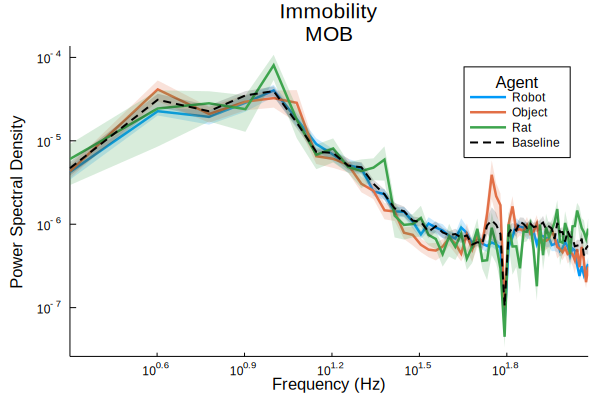

In [291]:
freqs=2:2:120;  b="Immobility"; r="MOB"
s=@subset(behavior_agent_mps, :behavior.== b, :region.== lowercase(r))
# s=@orderby(s, :agent)
labels =reshape(s.agent,1,length(s.agent)) 
# labels =map(x->"Agent: "*x, labels)
specs = s.mps
errs = s.err

gr()
p=plot(
    freqs, 
    specs, 
    ribbon=errs, 
    fillalpha=.2, 
    label=labels, 
    xaxis=:log,
    yaxis=:log, 
    ylabel="Power Spectral Density", 
    xlabel="Frequency (Hz)", 
    title=b*"\n"*r,
    linewidth=2.5,
    grid=false,
    
)
ns=@subset(null_region_mps, :region.== lowercase(r))
plot!(p, freqs, ns.mps, ribbon= ns.err, fillcolor=:black, fillalpha=.15, linewidth=2,  xlim=(2,120), linestyle=:dash, linecolor=:black, label="Baseline", legendtitle="Agent")




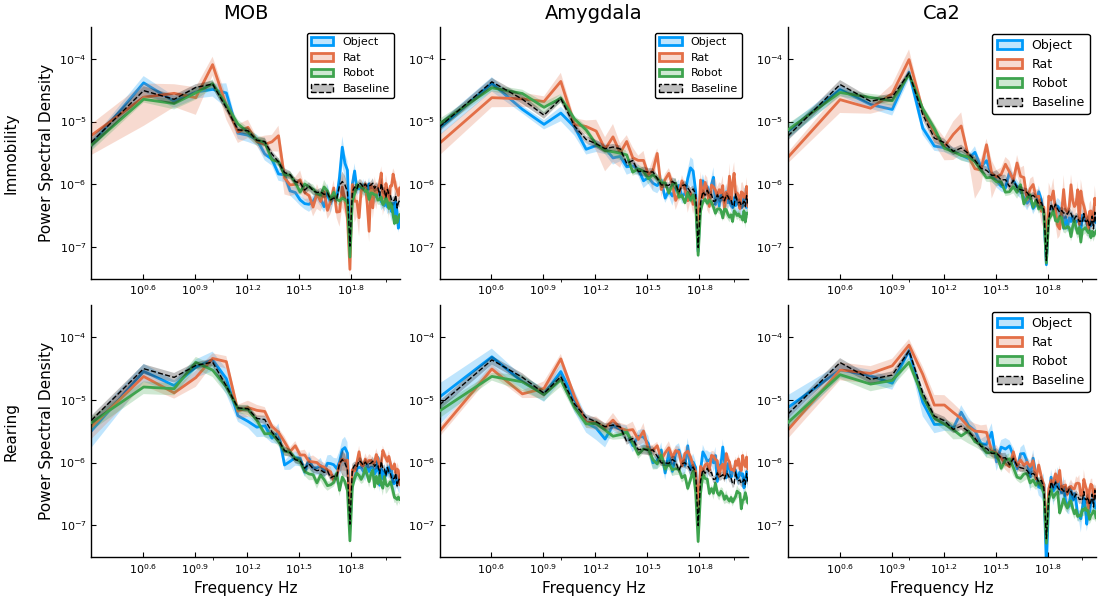

sys:1: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
sys:1: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


In [292]:
import PyPlot
pyplot()
imm_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "MOB")
plot!(imm_mob, title="MOB", xlabel="", ylabel="Immobility\n\nPower Spectral Density")
imm_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "Amyg")
plot!(imm_amyg, title="Amygdala", xlabel="")
imm_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Immobility", "CA2")
plot!(imm_ca, title="Ca2", xlabel="", legendfontsize = 9, legend = :topright)
rear_mob=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "MOB")
plot!(rear_mob, title="", xlabel="Frequency Hz", ylabel="Rearing\n\nPower Spectral Density")
rear_amyg=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "Amyg")
plot!(rear_amyg, title="", xlabel="Frequency Hz")
rear_ca=agent_ps_plot(behavior_agent_mps, null_region_mps, "Rearing", "CA2")
plot!(rear_ca, title="", xlabel="Frequency Hz", legendfontsize = 9, legend = :topright)

p=plot(imm_mob, imm_amyg, imm_ca, rear_mob, rear_amyg, rear_ca)
plot!(p, grid=false, size = (1100, 600))
plot!(p, yticks=[10.0^x for x in -7:1:-4], ylim=(10.0^-7.5, 10.0^-3.5), xlim=(2,120))
# plot!(p, linestyle=[:solid :solid :solid :dash], linewidth=[3 3 3 3])

# PyPlot.suptitle("Region")
# PyPlot.savefig("suptile_test.png")
